#Import

In [ ]:
!pip install spicy

In [ ]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load solution

In [ ]:
from spicy import io
import torch

mat_file = io.loadmat('/content/AC.mat')

In [ ]:
x1 = mat_file['x']
t1 = mat_file['tt']

ms_t1, ms_x1= np.meshgrid(t1,x1)

ob_x1 = np.ravel(ms_x1).reshape(-1,1)
ob_t1 = np.ravel(ms_t1).reshape(-1,1)

label_x = Variable(torch.from_numpy(ob_x1).float(), requires_grad=False).to(device)
label_t = Variable(torch.from_numpy(ob_t1).float(), requires_grad=False).to(device)

In [ ]:
Solution = mat_file['uu']
Solution1 = Variable(torch.from_numpy(Solution).float(), requires_grad=False).to(device)

Solution1.size()

torch.Size([512, 201])

#Build Network

In [ ]:
class Net_AC(nn.Module):
    def __init__(self):
        super(Net_AC, self).__init__()
        torch.manual_seed(1234) # Fix Initial_Parameter
        self.hidden_layer1 = nn.Linear(2,64)
        torch.manual_seed(1234)
        self.hidden_layer2 = nn.Linear(64,64)
        torch.manual_seed(1234)
        self.hidden_layer3 = nn.Linear(64,64)
        torch.manual_seed(1234)
        self.hidden_layer4 = nn.Linear(64,64)
        torch.manual_seed(1234)
        self.output_layer = nn.Linear(64,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1)
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)

        return output

#set PDE,residual

In [ ]:
N=100

In [ ]:
def f(x, t, net):
    u = net(x,t)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    pde = 1*u_t - 0.0001*N*N*u_xx + 5*u**3 - 5*u

    return pde

#Define Additional Partial Derivative

In [ ]:
def dt(x,t, net):
    u = net(x,t)

    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]

    return u_t

def dx(x,t, net):
    u = net(x,t)

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]

    return u_x

#loss,optimizer

In [ ]:
import torch
import torch.nn.init as init

mse_cost_function = torch.nn.MSELoss() #MSE Function can be shared

net_AC = Net_AC()
net_AC = net_AC.to(device)
optimizer = torch.optim.Adam(net_AC.parameters())

#Set Condition Data

In [ ]:
x_D = np.random.uniform(low = -N , high = N , size=(200,1))
t_D = np.random.uniform(low = 0 , high = 1 , size=(64,1))
x_S = np.ones((64,1))*(-N)
t_0 = np.zeros((200,1))
x_E = np.ones((64,1))*N

##---------------------------------Condition Label--------------------------------##

u_t0 = ((x_D/N)**2)*np.cos(np.pi/N*x_D)

##------------------------------------Condition data---------------------------------------##
C_x_D = Variable(torch.from_numpy(x_D).float(), requires_grad=True).to(device)
C_t_D = Variable(torch.from_numpy(t_D).float(), requires_grad=True).to(device)
C_x_S = Variable(torch.from_numpy(x_S).float(), requires_grad=True).to(device)
C_t_0 = Variable(torch.from_numpy(t_0).float(), requires_grad=True).to(device)
C_x_E = Variable(torch.from_numpy(x_E).float(), requires_grad=True).to(device)

##------------------------------------Condition Label---------------------------------------##
pt_u_t0 = Variable(torch.from_numpy(u_t0).float(), requires_grad=False).to(device)

all_zeros = np.zeros((10000,1))
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

#Train

In [ ]:
iterations = 100000
previous_validation_loss = 99999999.0

for epoch in range(iterations):
    optimizer.zero_grad()

##-------------------------------Condition predict output------------------------------------##
    net_xS_out = net_AC(C_x_S, C_t_D)
    net_xE_out = net_AC(C_x_E, C_t_D)
    net_xIC_out = net_AC(C_x_D, C_t_0)

    net_DxE_out = dx(C_x_E, C_t_D, net_AC)
    net_DxS_out = dx(C_x_S, C_t_D, net_AC)

##------------------------------------Condition Loss-----------------------------------------##
    mse_xSEt = mse_cost_function(net_xS_out, net_xE_out)
    mse_DxSEt = mse_cost_function(net_DxS_out, net_DxE_out)
    mse_xt0 = mse_cost_function(net_xIC_out, pt_u_t0)

##------------------------------------Set Interior Domain-----------------------------------------##
    x_collocation = np.random.uniform(low=-N, high=N, size=(10000,1))
    t_collocation = np.random.uniform(low=0, high=1, size=(10000,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)

##------------------------------------Compute Loss-----------------------------------------##
    f_out = f(pt_x_collocation, pt_t_collocation, net_AC)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    loss = 1*(mse_xSEt + mse_DxSEt + 2*mse_xt0) + 0.3*mse_f

##------------------------------------Optimize Loss-----------------------------------------##
    loss.backward()
    optimizer.step()

##----------------------------Result-----------------------------##
    if (epoch) % 50 == 0:
        predict = torch.reshape(net_AC(N*label_x,1*label_t),(512,201))
        gap = torch.sqrt((((Solution1 - predict)**2).mean())/((Solution1**2).mean()))

        print("-----------------------------------------------------------------------------")
        print("Epoch:",epoch)
        print(loss.item())
        print(gap.item())

-----------------------------------------------------------------------------
Epoch: 0
tensor(0.3542, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9815, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 10
tensor(0.3122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9755, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 20
tensor(0.3018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9744, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 30
tensor(0.2922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9627, device='cuda:0', grad_fn=<SqrtBackward0>)
-----------------------------------------------------------------------------
Epoch: 40
tensor(0.2817, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9497, device='cuda:0', grad_fn=<SqrtBackward

KeyboardInterrupt: 

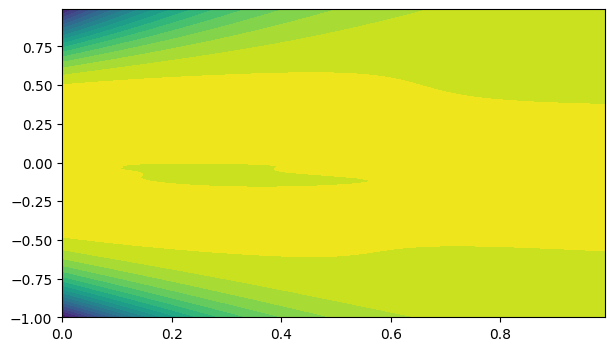

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


ob_x=np.arange(-1,1,0.01)
ob_t=np.arange(0,1,0.01)
ms_x, ms_t= np.meshgrid(ob_x,ob_t)

ob_x = np.ravel(ms_x).reshape(-1,1)
ob_t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(ob_x).float(), requires_grad=False).to(device)
pt_t = Variable(torch.from_numpy(ob_t).float(), requires_grad=False).to(device)

fig = plt.figure(figsize=(7,4))

pt_u = net_AC(N*pt_x,pt_t)

u = pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

plt.contourf(ms_t, ms_x , ms_u, levels=20)
plt.show()